`fdapde-py` is an Python package that implements the Physics-Informed Statistical Models available in the C++ library [fdaPDE](https://github.com/fdaPDE/fdaPDE-cpp). 

### Spatial Regression with Partial Differential Equation Regularization
Consider a bounded, regular, open domain $\Omega\subset \mathbb{R}^d$ and a regular function $f:\Omega \rightarrow \mathbb{R}$ to be estimated from noisy observations.
Let $y_i, \text{ for }i = 1,\ldots,n,$ be $n$ observations that represent noisy evaluations of the field $f$ at points $\mathbf{p}_i \in \Omega$. 
Consider the following additive semiparametric model: 

$$y_i = \mathbf{x}^\top_i \mathbf{\beta} + f(\mathbf{p}_i) + \epsilon_i,$$
where $\epsilon_i, \ i=1, \ldots, n$ are $n$ independent errors with zero mean and finite variance. The SRPDE method estimates the two unknown $\beta \in \mathbb{R}^q$ and $f \in V$ by minimizing the following functional:
\begin{equation}
	(\hat{\mathbf{\beta}}, \hat{f}) := \text{argmin} \ \left\{\frac{1}{n}\sum_{i=1}^{n}(y_i-\mathbf{x}^\top_i \mathbf{\beta} - \mathit{f}(\mathbf{p}_{i}))^{2} + \lambda \left\lVert \mathcal{L}f - u \right\lVert_{L^2(G)}^2 \right\}.
\end{equation}
The functional is composed of a data fitting criterion, consisting of classical least
square errors, and a model fitting criterion, formalized as a roughness term that penalizes
the misfit of a PDE governing the phenomenon.
The positive smoothing parameter $\lambda$ balances the data adaptation and the model fitting criterion.

#### Solving a nonparametric SRPDE problem in Python
This example considers a nonparametric spatial regression problem over the unit square domain $\Omega$. Consider $f_{ex}(x,y) = \sin(2\pi x) \sin(2 \pi y)$ as the true spatial field for this application, i.e., the function we want to estimate. The observations are obtained by evaluating the true spatial field at $n$ locations uniformly scattered over $\Omega$, and adding Gaussian noise with variance equal to the $5\%$ of the range of the true function: 
$$y_i = f_{ex}(\mathbf{p}_i) + \epsilon_i.$$

The following window wraps all the steps needed to solve the problem.

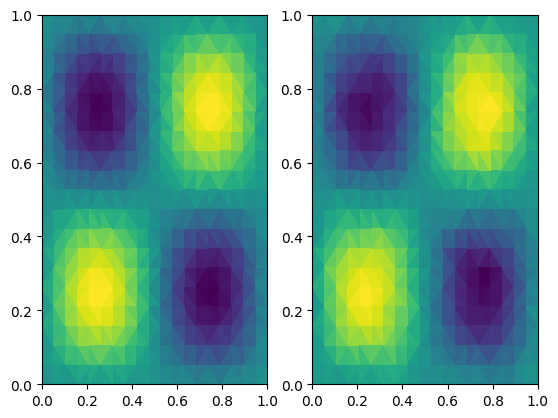

In [1]:
import fdapdepy as fdapde
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

# data generation
nlocs = 500
p0 = np.random.uniform(0,1,nlocs)
p1 = np.random.uniform(0,1,nlocs)
f_ex = lambda p0, p1 : np.sin(2*np.pi*p0) * np.sin(2*np.pi*p1)
f_ = f_ex(p0,p1)
f_ =  f_.reshape((f_.shape[0],1))
obs = f_ + 0.05 * np.random.randn(nlocs,1)
data = pd.DataFrame(np.matrix([obs.reshape(-1), p0, p1]).transpose(), columns=["y", "p0", "p1"])
# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
nodes.shape
mesh = fdapde.domain(nodes, triangles, boundary)
# unknown spatial field
basis = fdapde.functional_basis(mesh, 1)
basis.size()
f = fdapde.function(basis)
Lf = -fdapde.laplacian(f)  
penalty = fdapde.pde(Lf) # forcing == 0.
# statistical model 
model = fdapde.srpde(formula="y ~ f(p0,p1)", data=data, 
                     penalty=penalty)

gcv = fdapde.gcv(lambda_= np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))
model.fit(calibration=gcv)
    
fig, ax = plt.subplots(1,2)
ax[0].tripcolor(nodes[:,0], nodes[:,1], f_ex(nodes[:,0], nodes[:,1]))
ax[0].set(xlim=(0, 1), ylim=(0, 1))

ax[1].tripcolor(nodes[:,0], nodes[:,1], model.f().reshape(-1))
ax[1].set(xlim=(0, 1), ylim=(0, 1))
plt.show()


The following sections explain more in detail the previous chunk of code.

##### Defining the domain
First, we create a proper domain object exploiting the function `domain` which takes three numpy matrix as parameters.

* `nodes`, a 2-columns matrix containing the coordinates of the nodes of the mesh. 

* `elements`, a 3-columns matrix that for each row $i$ contains the indexes of the mesh nodes that are vertices of the $i$-th element.

* `boundary`, a 1-column matrix that indicates the nodes on the boundary of the domain. 


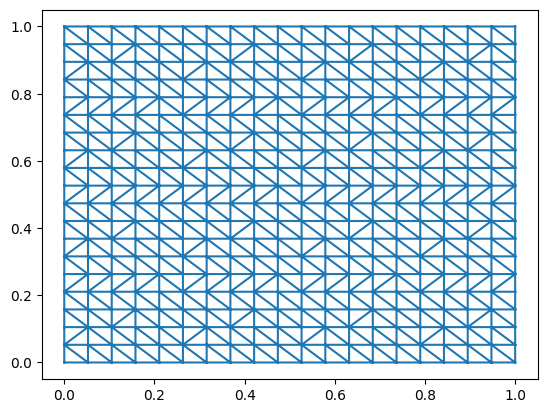

In [2]:
# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
nodes.shape
mesh = fdapde.domain(nodes, triangles, boundary)

triangulation = Triangulation(mesh.nodes()[:,0], mesh.nodes()[:,1], mesh.elements())
fig, ax = plt.subplots()
ax.triplot(triangulation)

##### Defining the solution of the PDE and the differential operator
First, we initialize a `BasisFunction` object passing the mesh we previously built and the finite element order. Note that, the package provides first order and second order finite elements.
The first-order finite element is the default parameter.
Then, we define a FE `function` which is the discrete estimator for $f_{ex}$ and the differential operator in its strong formulation. 

In [3]:
basis = fdapde.functional_basis(mesh, 1)
# discrete estimator
f = fdapde.function(basis)
Lf = -fdapde.laplacian(f)  

##### Defining the penalty term
We define the penalty term as a `pde` object which takes as argument the differential operator in its strong formulation and the forcing term, which is set to 0 as default parameter.

Note that $f_{ex}$ satisfies the following partial differential equation:
$$
\begin{cases}
-\Delta f = u  &in \ \Omega \\
      \quad u = 0  &on \ \partial \Omega
\end{cases}
$$

where $u(x,y) = 8\pi^2 \sin( 2\pi x)\sin(2\pi y)$ is the forcing term and $\partial \Omega$ is the boundary of $\Omega$ where we have prescribed homogeneous Dirichelet boundary condition.

Note that we are assuming no information about the specific problem at hand. Indeed, we set neither the forcing term, which is known for this simple simulation study, nor the Dirichlet boundary condition.

In [4]:
penalty = fdapde.pde(Lf) # forcing == 0, NO Dirichlet BC

##### Defining the SRPDE model
We define the SRPDE passing as arguments a R-like formula, a pandas `DataFrame` and the penalty object previously instantiated. Then, we fit the model by calling the `fit` method which takes `calibration` as optional parameter.

In [5]:
model = fdapde.srpde(formula="y ~ f(p0,p1)", data=data, 
                     penalty=penalty)

gcv = fdapde.gcv(lambda_= np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))
model.fit(calibration=gcv)

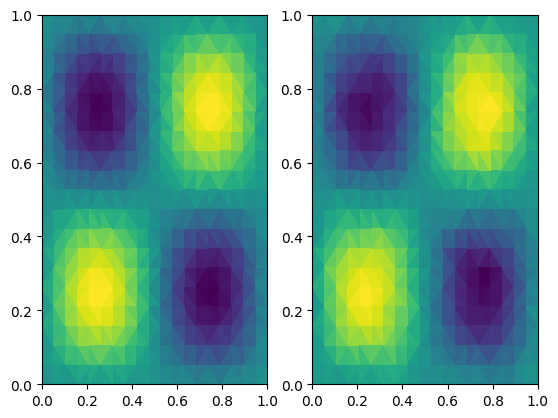

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].tripcolor(nodes[:,0], nodes[:,1], f_ex(nodes[:,0], nodes[:,1]))
ax[0].set(xlim=(0, 1), ylim=(0, 1))

ax[1].tripcolor(nodes[:,0], nodes[:,1], model.f().reshape(-1))
ax[1].set(xlim=(0, 1), ylim=(0, 1))
plt.show()

##### Numerical consistency of the SRPDE

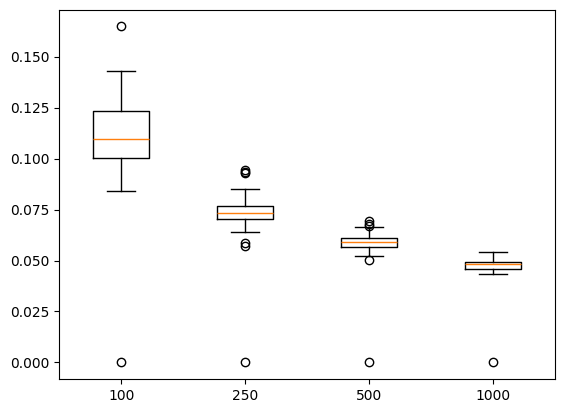

In [7]:
nlocs = [100, 250, 500, 1000]
nsim = 50
errors = np.zeros((nsim,len(nlocs)))

# true spatial field
f_ex = lambda p0, p1 : np.sin(2*np.pi*p0) * np.sin(2*np.pi*p1)

# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
nodes.shape
mesh = fdapde.domain(nodes, triangles, boundary)
# FE basis
basis = fdapde.functional_basis(mesh, 1)
f = fdapde.function(basis)
Lf = -fdapde.laplacian(f)  
penalty = fdapde.pde(Lf) # forcing == 0.
gcv = fdapde.gcv(lambda_= np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))

def rmse(x,y):
    return np.sqrt( np.mean( (x-y)*(x-y) ))

for i in range(0,len(nlocs)):
    for j in range(0,nsim-1):
        p0 = np.random.uniform(0,1,nlocs[i])
        p1 = np.random.uniform(0,1,nlocs[i])
        f_ = f_ex(p0,p1)
        f_ =  f_.reshape((f_.shape[0],1))
        obs = f_ + 0.05 * np.random.randn(nlocs[i],1)
        data = pd.DataFrame(np.matrix([obs.reshape(-1), p0, p1]).transpose(), columns=["y", "p0", "p1"])
        model = fdapde.srpde(formula="y ~ f(p0,p1)", data=data, 
                             penalty=penalty)
        model.fit(calibration=gcv)
        errors[j,i] = rmse( model.f(), f_ex(nodes[:,0], nodes[:,1]))

fig, ax = plt.subplots()
_ = ax.boxplot(errors, tick_labels=nlocs)